In [1]:
import torch
import torchvision 
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import time 
from matplotlib import pyplot as plt

In [13]:
cifar_norm_mean = (0.49139968, 0.48215827, 0.44653124)
cifar_norm_std = (0.24703233, 0.24348505, 0.26158768)
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cifar_norm_mean, cifar_norm_std),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar_norm_mean, cifar_norm_std),
])
root = './data/'
train_set = torchvision.datasets.CIFAR10(root=root,train=True,transform=transform_train,download=True)
test_set = torchvision.datasets.CIFAR10(root=root,train=False,transform=transform_test,download=True)
train_load = DataLoader(train_set,batch_size=128,shuffle=True)
test_load = DataLoader(test_set,batch_size=128,shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
class BasicNet(nn.Module):
  def __init__(self,in_channel,out_channel,stride=1):
    super(BasicNet,self).__init__()
    self.left = nn.Sequential(
         nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=stride, padding=1, bias=False),
         nn.BatchNorm2d(out_channel),
         nn.ReLU(inplace=True),
         nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=1, padding=1, bias=False),
         nn.BatchNorm2d(out_channel)
    )
    self.shortcut = nn.Sequential()
    if stride != 1 or in_channel != out_channel :
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_channel,out_channel,1,stride=stride,bias=False),
          nn.BatchNorm2d(out_channel)
      )
    
  def forward(self,x):
    # print('-----basic net -----')
    # print('X:',x.size())
    out = self.left(x)
    t = self.shortcut(x)
    # print('T:',t.size)
    out += t
    out = F.relu(out)
    return out

In [7]:
class ResNet(nn.Module):
  def __init__(self):
    super(ResNet18,self).__init__()
    self.in_channel = 64
    self.conv1 = nn.Sequential(
        nn.Conv2d(3,64,5,stride=1,padding=1,bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        # nn.MaxPool2d(3)
    )
    self.conv2 = self.create_conv_layer(BasicNet,64,3,stride=1)
    self.conv3 = self.create_conv_layer(BasicNet,128,4,stride=2)
    self.conv4 = self.create_conv_layer(BasicNet,256,6,stride=2)
    self.conv5 = self.create_conv_layer(BasicNet,512,3,stride=2)
    self.fc = nn.Sequential(
        nn.Linear(512,256),
        nn.ReLU(inplace=True),
        nn.Linear(256,128),
        nn.ReLU(inplace=True),
        nn.Linear(128,10)
    )


  def forward(self,x):
    x = self.conv1(x)
    # print('conv1:',x.size())
    x = self.conv2(x)
    # print('conv2:',x.size())
    x = self.conv3(x)
    # print('conv3:',x.size())
    x = self.conv4(x)
    x = self.conv5(x)
    # print('conv5:',x.size())
    x = F.avg_pool2d(x, 4)
    x = x.view(x.size(0),-1)
    # print('view x:',x.size())
    x = self.fc(x)
    return x

  def create_conv_layer(self,block,channels,num_blocks,stride):
    layers = []
    for i in range(num_blocks):
      if i == 0:
        layers.append(block(self.in_channel,channels,stride))
      else :
        layers.append(block(channels,channels,1))
      self.in_channel = channels
    return nn.Sequential(*layers)

In [5]:
def show(loss,score,epoch):
  fig, ax = plt.subplots()
  ax.plot(epoch, loss, label='loss')
  ax.plot(epoch, score, label='score')
  legend = ax.legend(fontsize='x-large')
  plt.show()

lr: 0.05
准确率:0.4944%
epoch:1 loss:1.2792---use time:51.04s
epoch:2 loss:1.2211---use time:51.00s
epoch:3 loss:0.8443---use time:50.99s
epoch:4 loss:0.5089---use time:51.00s
epoch:5 loss:0.9761---use time:51.00s
epoch:6 loss:0.6779---use time:51.00s
epoch:7 loss:0.2771---use time:50.99s
epoch:8 loss:0.4942---use time:51.00s
epoch:9 loss:0.4602---use time:51.00s
epoch:10 loss:0.5269---use time:51.01s
准确率:0.8255%
epoch:11 loss:0.5402---use time:51.00s
epoch:12 loss:0.4536---use time:51.00s
epoch:13 loss:0.2502---use time:50.99s
epoch:14 loss:0.2196---use time:51.00s
epoch:15 loss:0.0901---use time:50.99s
epoch:16 loss:0.1832---use time:51.00s
epoch:17 loss:0.1562---use time:51.00s
epoch:18 loss:0.1288---use time:51.01s
epoch:19 loss:0.0587---use time:51.01s
epoch:20 loss:0.2117---use time:51.01s
准确率:0.8283%
epoch:21 loss:0.1627---use time:51.00s
epoch:22 loss:0.2622---use time:51.00s
epoch:23 loss:0.2733---use time:50.99s
epoch:24 loss:0.3145---use time:51.00s
epoch:25 loss:0.2322---use t

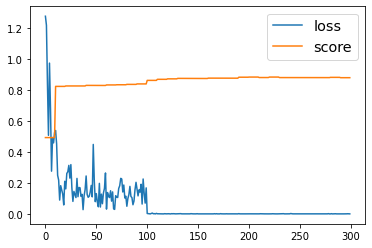

In [8]:
# train_load = DataLoader(train_set,batch_size=128,shuffle=True)
# test_load = DataLoader(test_set,batch_size=128,shuffle=True)
model = ResNet()
ce = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0005, momentum=0.9, weight_decay=5e-4)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
loss_list = []
score_list = []
# fc 三层 512 -> 256 -> 128
lr_list = [0.05,0.005,0.0001]
for epoch in range(300):
  if epoch % 100 == 0 :
    first = lr_list[0] 
    print('lr:',first)
    lr_list.remove(first)
    optimizer = torch.optim.SGD(model.parameters(), lr=first, momentum=0.9, weight_decay=5e-4)
  start_time = time.time()
  for i,data in enumerate(train_load):
    inputs,labels = data
    inputs,labels = inputs.to(device),labels.to(device)
    output = model.forward(inputs)
    # print('output:',output.size())
    loss = ce(output,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  finish_time = time.time()
  correct = 0
  total = 0
  if epoch % 10 == 0 :
    for i,data in enumerate(test_load):
      inputs,labels = data 
      inputs,labels = inputs.to(device),labels.to(device)
      output = model.forward(inputs)
      _, pred = torch.max(output.data,1)
      total = total + labels.size(0)
      correct = correct + (pred == labels).sum().item()
    score = correct/total
    print('准确率:{:.4f}%'.format(score))
  print('epoch:{} loss:{:.4f}---use time:{:.2f}s'.format(epoch+1,loss,finish_time-start_time))
  loss_list.append(loss)
  score_list.append(score)
show(loss_list,score_list,list(range(len(loss_list))))

In [11]:
correct = 0
total = 0
for i,data in enumerate(test_load):
    inputs,labels = data 
    inputs,labels = inputs.to(device),labels.to(device)
    output = model.forward(inputs)
    _, pred = torch.max(output.data,1)
    total = total + labels.size(0)
    correct = correct + (pred == labels).sum().item()
score = correct/total
print('准确率:{:.4f}%'.format(score))

准确率:0.8823%


In [12]:
model300 = model

lr: 0.001
epoch:1 loss:0.0649---use time:51.04s
准确率:0.9126%
epoch:2 loss:0.1169---use time:51.02s
准确率:0.9122%
epoch:3 loss:0.0576---use time:51.04s
准确率:0.9117%
epoch:4 loss:0.0319---use time:51.05s
准确率:0.9127%
epoch:5 loss:0.0879---use time:51.05s
准确率:0.9117%
lr: 0.0005
epoch:6 loss:0.0162---use time:51.06s
准确率:0.9133%
epoch:7 loss:0.0381---use time:51.07s
准确率:0.9119%
epoch:8 loss:0.0460---use time:51.07s
准确率:0.9117%
epoch:9 loss:0.0115---use time:51.07s
准确率:0.9129%
epoch:10 loss:0.0673---use time:51.07s
准确率:0.9117%


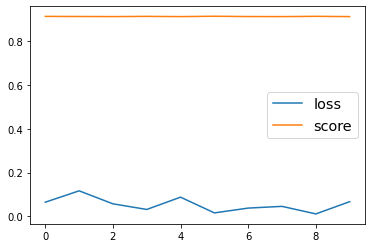

In [15]:
# model = ResNet18()
# ce = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0005, momentum=0.9, weight_decay=5e-4)
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# model.to(device)
loss_list = []
score_list = []
# 数据曾广后训练的
# fc 三层 512 -> 256 -> 128
# 在前面30次基础上继续训练的
lr_list = [0.001,0.0005]
for epoch in range(10):
  if epoch % 5 == 0 :
    first = lr_list[0] 
    print('lr:',first)
    lr_list.remove(first)
    optimizer = torch.optim.SGD(model.parameters(), lr=first, momentum=0.9, weight_decay=5e-4)
  start_time = time.time()
  for i,data in enumerate(train_load):
    inputs,labels = data
    inputs,labels = inputs.to(device),labels.to(device)
    output = model.forward(inputs)
    # print('output:',output.size())
    loss = ce(output,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  finish_time = time.time()
  correct = 0
  total = 0
 
  for i,data in enumerate(test_load):
    inputs,labels = data 
    inputs,labels = inputs.to(device),labels.to(device)
    output = model.forward(inputs)
    _, pred = torch.max(output.data,1)
    total = total + labels.size(0)
    correct = correct + (pred == labels).sum().item()
  score = correct/total
  
  print('epoch:{} loss:{:.4f}---use time:{:.2f}s'.format(epoch+1,loss,finish_time-start_time))
  print('准确率:{:.4f}%'.format(score))
  loss_list.append(loss)
  score_list.append(score)
show(loss_list,score_list,list(range(len(loss_list))))